# Comparison of solvers

This notebook shows how to estimate the counterfactual with Scipy and PyMC5 and creates comparison plots with reference test data included in the ATTRICI repository. 

In [1]:
%matplotlib inline
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
from loguru import logger

from attrici.detrend import Config, detrend

logger.remove()

## Estimation and comparison to desired/target data

In [2]:
variable_name = "tas"

## PyMC5 run

In [3]:
config = Config(
    gmt_file=Path("../tests/data/20CRv3-ERA5_germany_ssa_gmt.nc"),
    input_file=Path("../tests/data/20CRv3-ERA5_germany_obs.nc"),
    mask_file=Path("../tests/data/mask_lat50.75_lon9.25.nc"),
    variable=variable_name,
    output_dir=Path("../tests/data/output/pymc5"),
    overwrite=True,
    report_variables=["y", "cfact"],
    solver="pymc5",
    stop_date="2021-12-31",
)
detrend(config)

data_pymc5 = xr.load_dataset(
    f"../tests/data/output/pymc5/timeseries/{variable_name}/lat_50.75/ts_lat50.75_lon9.25.nc"
)

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Scipy run

In [4]:
config = Config(
    gmt_file=Path("../tests/data/20CRv3-ERA5_germany_ssa_gmt.nc"),
    input_file=Path("../tests/data/20CRv3-ERA5_germany_obs.nc"),
    mask_file=Path("../tests/data/mask_lat50.75_lon9.25.nc"),
    variable=variable_name,
    output_dir=Path("../tests/data/output/scipy"),
    overwrite=True,
    report_variables=["y", "cfact"],
    solver="scipy",
    stop_date="2021-12-31",
)
detrend(config)

data_scipy = xr.load_dataset(
    f"../tests/data/output/scipy/timeseries/{variable_name}/lat_50.75/ts_lat50.75_lon9.25.nc"
)

Now load the target ('desired') data and store both `desired` and `scipy` counterfactuals in the date frame:

In [5]:
data = pd.read_hdf(
    f"../tests/data/20CRv3-ERA5_germany_target_{variable_name}_lat50.75_lon9.25.h5"
)
data["time"] = data.ds
data = data.drop("ds", axis=1)
data.index = data.time
data["desired"] = data.cfact
data = data.to_xarray()
data["pymc5"] = data_pymc5.cfact
data["scipy"] = data_scipy.cfact

In [6]:
data

<xarray.Dataset> Size: 2MB
Dimensions:  (time: 44925, lat: 1, lon: 1)
Coordinates:
  * time     (time) datetime64[ns] 359kB 1901-01-01 1901-01-02 ... 2023-12-31
  * lat      (lat) float64 8B 50.75
  * lon      (lon) float64 8B 9.25
Data variables:
    y        (time) float32 180kB 266.0 263.6 263.4 263.0 ... 281.5 280.2 279.5
    cfact    (time) float64 359kB 265.9 263.5 263.4 263.0 ... 279.5 278.2 277.5
    logp     (time) float64 359kB 10.57 10.57 10.57 10.57 ... 10.57 10.57 10.57
    desired  (time) float64 359kB 265.9 263.5 263.4 263.0 ... 279.5 278.2 277.5
    pymc5    (time, lat, lon) float64 359kB 265.9 263.5 263.4 ... 278.2 277.5
    scipy    (time, lat, lon) float64 359kB 265.9 263.5 263.4 ... 278.2 277.5

### Differences

Differences between both time series (actual and desired) are:

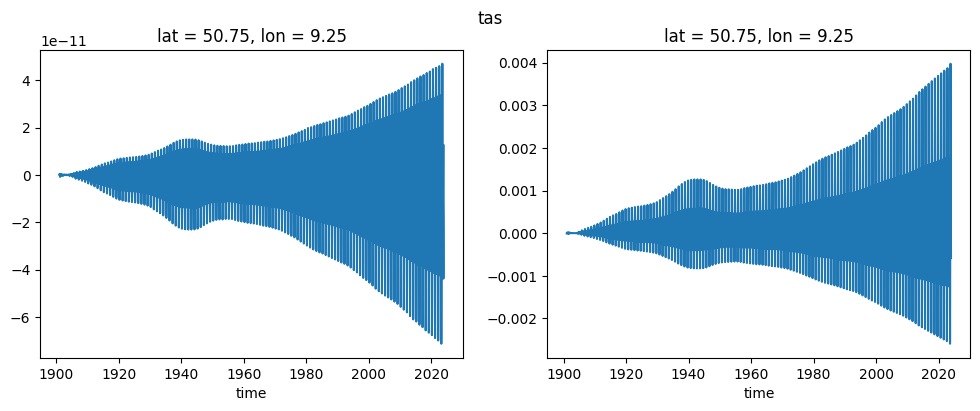

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle(variable_name)
ax[0].set_title("PyMC5")
ax[1].set_title("Scipy")
(data.desired - data.pymc5).plot(ax=ax[0])
(data.desired - data.scipy).plot(ax=ax[1]);

A single year for comparison

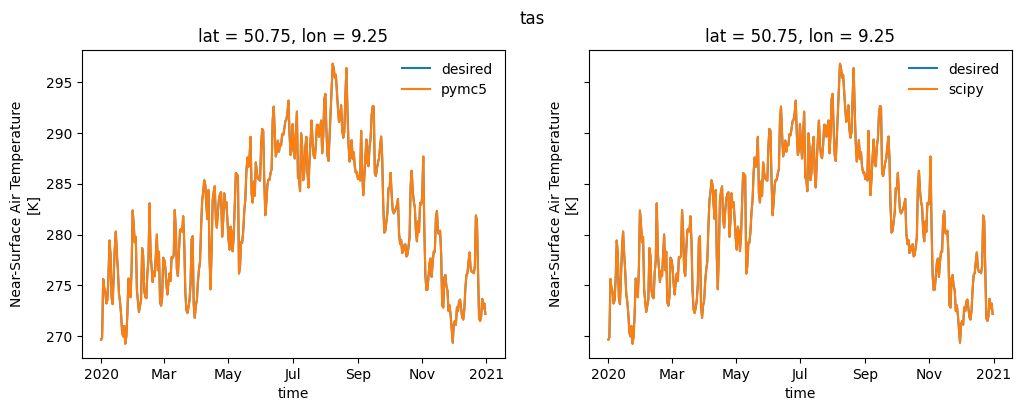

In [8]:
year = "2020"

fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
fig.suptitle(variable_name)
ax[0].set_title("PyMC5")
ax[1].set_title("Scipy")

data.desired.loc[year].plot(ax=ax[0], label="desired")
data.pymc5.loc[year].plot(ax=ax[0], label="pymc5")
ax[0].legend(frameon=False)
data.desired.loc[year].plot(ax=ax[1], label="desired")
data.scipy.loc[year].plot(ax=ax[1], label="scipy")
ax[1].legend(frameon=False);

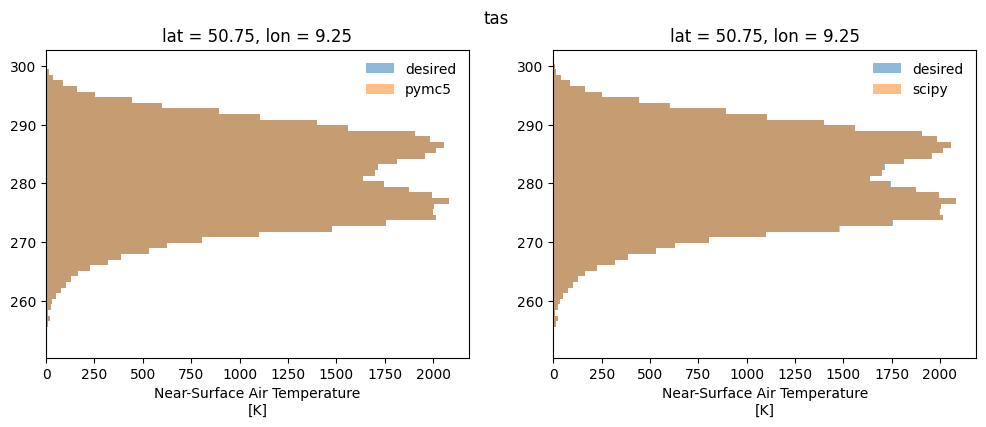

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle(variable_name)
ax[0].set_title("PyMC5")
ax[1].set_title("Scipy")

data.desired.plot.hist(
    ax=ax[0], bins=50, label="desired", orientation="horizontal", alpha=0.5
)
data.pymc5.plot.hist(
    ax=ax[0], bins=50, label="pymc5", orientation="horizontal", alpha=0.5
)
ax[0].legend(frameon=False)
data.desired.plot.hist(
    ax=ax[1], bins=50, label="desired", orientation="horizontal", alpha=0.5
)
data.scipy.plot.hist(
    ax=ax[1], bins=50, label="scipy", orientation="horizontal", alpha=0.5
)
ax[1].legend(frameon=False);